In [1]:
import pandas as pd 
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
data = pd.read_csv("C:\\Users\\admin\\Desktop\\bank_transactions.csv")

In [3]:
data.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [4]:
data = data.dropna()

In [5]:
def parse_dob(date_str):
    try:
        return pd.to_datetime(date_str, format='%d/%m/%y')
    except ValueError: 
        return pd.to_datetime(date_str, format='%d/%m/%Y')


data['CustomerDOB'] = data['CustomerDOB'].apply(parse_dob)
current_date = datetime.now()
data['Age'] = (current_date - data['CustomerDOB']).astype('<m8[Y]')

data.drop(columns=['CustomerDOB'], inplace=True)

In [6]:
data['Age'] = data['Age'].apply(lambda x: x + 100 if x < 0 else x)

In [7]:
data

,TransactionID,CustomerID,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age
0,T1,C5841053,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0,29.0
1,T2,C2142763,M,JHAJJAR,2270.69,2/8/16,141858,27999.0,66.0
2,T3,C4417068,F,MUMBAI,17874.44,2/8/16,142712,459.0,26.0
3,T4,C5342380,F,MUMBAI,866503.21,2/8/16,142714,2060.0,49.0
4,T5,C9031234,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5,35.0
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,M,NEW DELHI,7635.19,18/9/16,184824,799.0,33.0
1048563,T1048564,C6459278,M,NASHIK,27311.42,18/9/16,183734,460.0,31.0
1048564,T1048565,C6412354,M,HYDERABAD,221757.06,18/9/16,183313,770.0,34.0
1048565,T1048566,C6420483,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0,45.0


In [8]:
data_types = data.dtypes

In [9]:
data_types

TransactionID               object
CustomerID                  object
CustGender                  object
CustLocation                object
CustAccountBalance         float64
TransactionDate             object
TransactionTime              int64
TransactionAmount (INR)    float64
Age                        float64
dtype: object

In [10]:
data.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR),Age
count,1.041614e+06,1.041614e+06,1.041614e+06,1.041614e+06
mean,1.149986e+05,1.571221e+05,1.566096e+03,4.773501e+01
std,8.467609e+05,5.126352e+04,6.561464e+03,4.274885e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.728140e+03,1.240410e+05,1.600000e+02,3.200000e+01
50%,1.676852e+04,1.642470e+05,4.575000e+02,3.600000e+01
75%,5.742885e+04,2.000220e+05,1.200000e+03,4.300000e+01
max,1.150355e+08,2.359590e+05,1.560035e+06,2.230000e+02


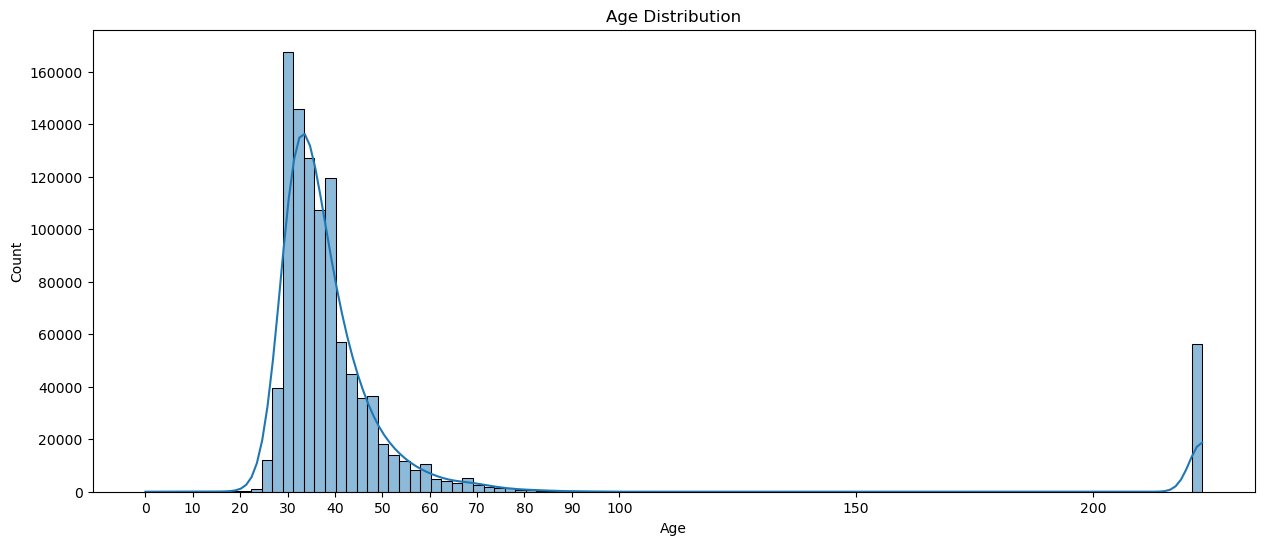

In [11]:
plt.figure(figsize=(15, 6))
sns.histplot(data['Age'], bins=100, kde=True)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200], ['0', '10', '20', '30', '40','50','60','70','80','90','100','150','200'])
plt.title('Age Distribution')
plt.show()

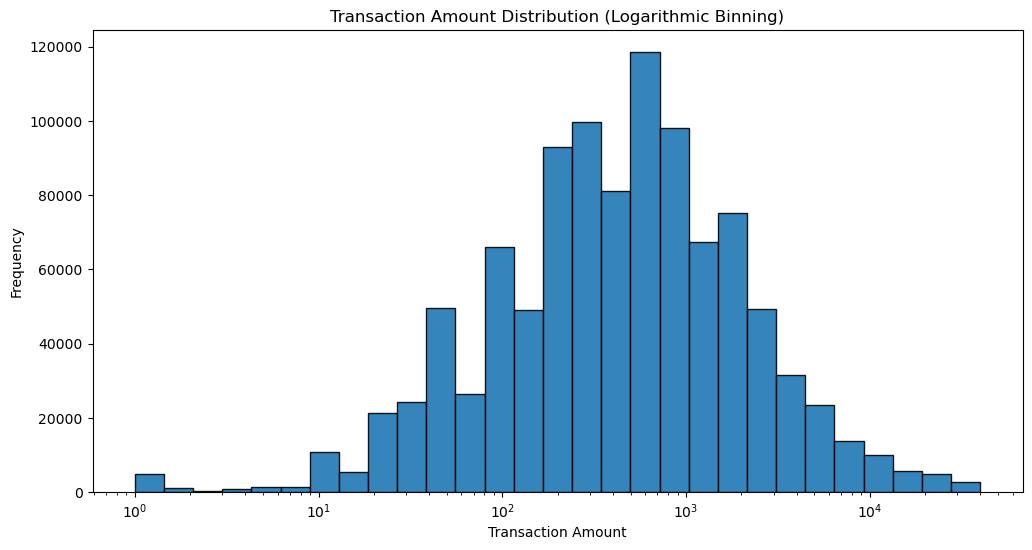

In [12]:
log_bins = np.logspace(np.log10(1), np.log10(40000), 30)  

plt.figure(figsize=(12, 6))
plt.hist(data['TransactionAmount (INR)'], bins=log_bins, edgecolor='k', alpha=0.9)
plt.xscale('log')  
plt.title('Transaction Amount Distribution (Logarithmic Binning)')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

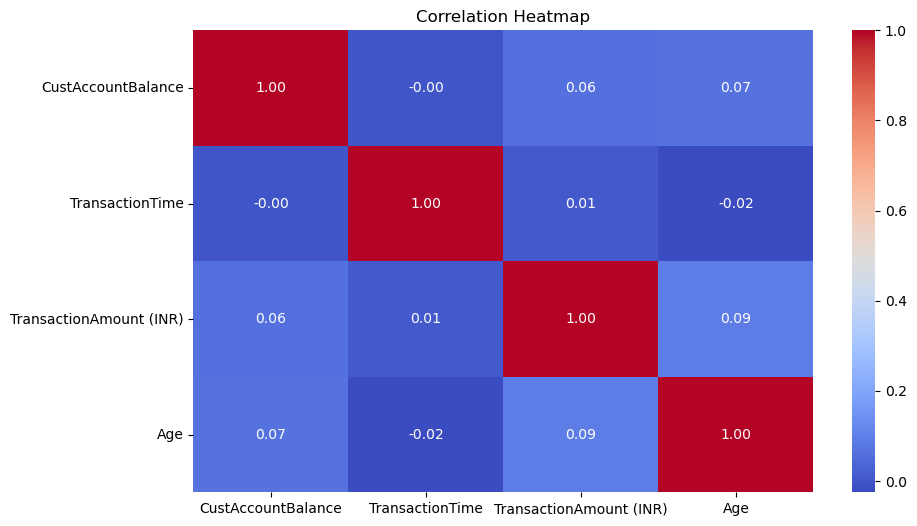

In [13]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [14]:
from datetime import timedelta

data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
current_date = data['TransactionDate'].max()

rfm_df = data.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (current_date - x.max()).days,  # Recency
    'TransactionAmount (INR)': ['count', 'sum']  # Frequency and Monetary
}).reset_index()

rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Merge RFM features back into the original dataset
data = pd.merge(data, rfm_df, on='CustomerID', how='left')

In [15]:
def parse_transaction_time(time_value):
    try:
        time_str = str(time_value)
        if len(time_str) == 6:
            return datetime.strptime(time_str, '%H%M%S')
        else:
            return None  
    except ValueError:
        return None  


data['TransactionTime'] = data['TransactionTime'].apply(parse_transaction_time)
data = data.dropna(subset=['TransactionTime'])

bins = [0, 60000, 120000, 180000, 240000]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']

data['TimeOfDay'] = pd.cut(data['TransactionTime'].dt.hour * 10000 + data['TransactionTime'].dt.minute * 100 + data['TransactionTime'].dt.second, bins=bins, labels=labels)

In [16]:
data.head()

,TransactionID,CustomerID,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age,Recency,Frequency,Monetary,TimeOfDay
0,T1,C5841053,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,29.0,305,1,25.0,Afternoon
1,T2,C2142763,M,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,66.0,305,1,27999.0,Afternoon
2,T3,C4417068,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,26.0,305,1,459.0,Afternoon
3,T4,C5342380,F,MUMBAI,866503.21,2016-02-08,1900-01-01 14:27:14,2060.0,49.0,118,2,2938.4,Afternoon
4,T5,C9031234,F,NAVI MUMBAI,6714.43,2016-02-08,1900-01-01 18:11:56,1762.5,35.0,305,1,1762.5,Evening


In [17]:
age_bins = [0, 18, 35, 50, 100]  
age_labels = ['Under 18', '18-35', '36-50', '50+']  

data['AgeGroup'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels)


In [18]:
data.drop(columns = ['TransactionDate' ,'TransactionTime'], inplace = True)

In [19]:
categorical_columns = ['CustGender', 'TimeOfDay', 'AgeGroup']

data = pd.get_dummies(data, columns=categorical_columns)

In [20]:
from sklearn.cluster import KMeans

In [21]:
import warnings


warnings.filterwarnings("ignore")

In [22]:
X = data[['Recency', 'Frequency', 'Monetary']]
rfm_inertia_val = []
k_values = range(5,25)
deneme_data = data.copy()
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    deneme_data['Cluster'] = kmeans.fit_predict(X)
    RFM_inertia = kmeans.inertia_
    rfm_inertia_val.append(RFM_inertia)


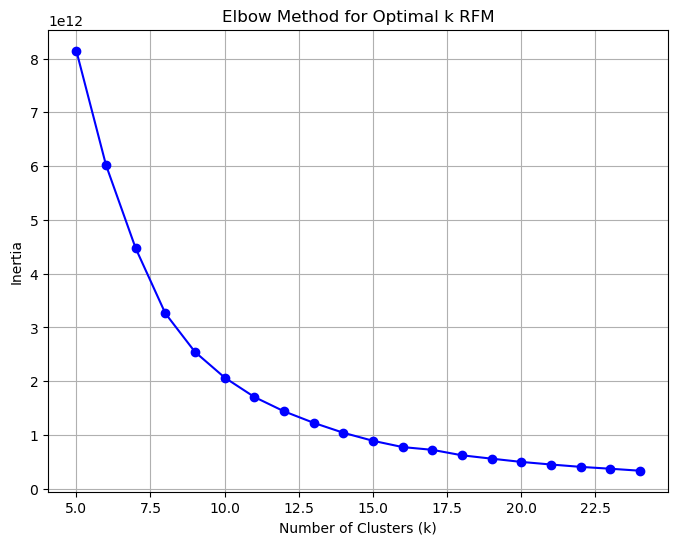

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(k_values, rfm_inertia_val, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k RFM')
plt.xlabel('Number of Clusters (k)')
#.ticklabel_format(style='plain', axis='y')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
X_scaled = StandardScaler().fit_transform(X)

In [50]:
scaled_rfm_inertia_val = []
k_values= range(8,25)
scaled_deneme = data.copy()
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    scaled_deneme['Cluster'] = kmeans.fit_predict(X_scaled)
    scaled_rfm_inertia = kmeans.inertia_
    scaled_rfm_inertia_val.append(scaled_rfm_inertia)

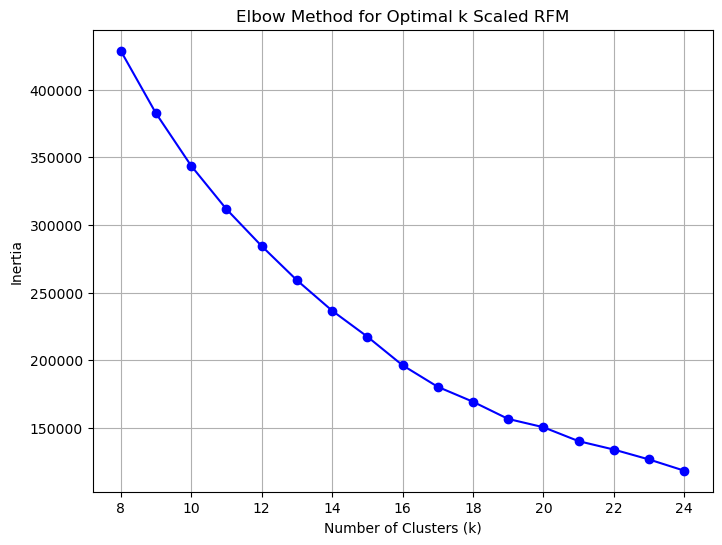

In [51]:
plt.figure(figsize=(8, 6))
plt.plot(k_values, scaled_rfm_inertia_val, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k Scaled RFM')
plt.xlabel('Number of Clusters (k)')
#.ticklabel_format(style='plain', axis='y')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [28]:
selected_features = data.copy()
selected_features.drop(columns = ['TransactionID','CustomerID','TransactionAmount (INR)','Age'],inplace = True)

In [29]:
Num_st = ['CustAccountBalance','Recency','Frequency','Monetary']

In [30]:
selected_features

,CustLocation,CustAccountBalance,Recency,Frequency,Monetary,CustGender_F,CustGender_M,CustGender_T,TimeOfDay_Night,TimeOfDay_Morning,TimeOfDay_Afternoon,TimeOfDay_Evening,AgeGroup_Under 18,AgeGroup_18-35,AgeGroup_36-50,AgeGroup_50+
0,JAMSHEDPUR,17819.05,305,1,25.0,1,0,0,0,0,1,0,0,1,0,0
1,JHAJJAR,2270.69,305,1,27999.0,0,1,0,0,0,1,0,0,0,0,1
2,MUMBAI,17874.44,305,1,459.0,1,0,0,0,0,1,0,0,1,0,0
3,MUMBAI,866503.21,118,2,2938.4,1,0,0,0,0,1,0,0,0,1,0
4,NAVI MUMBAI,6714.43,305,1,1762.5,1,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041609,NEW DELHI,7635.19,82,1,799.0,0,1,0,0,0,0,1,0,1,0,0
1041610,NASHIK,27311.42,82,1,460.0,0,1,0,0,0,0,1,0,1,0,0
1041611,HYDERABAD,221757.06,82,2,978.0,0,1,0,0,0,0,1,0,1,0,0
1041612,VISAKHAPATNAM,10117.87,82,1,1000.0,0,1,0,0,0,0,1,0,0,1,0


In [31]:
scaler = StandardScaler()
selected_copy = selected_features.copy()
selected_copy[Num_st] = scaler.fit_transform(selected_copy[Num_st])

In [32]:
#Frequency encoding
loc_counts = selected_features['CustLocation'].value_counts()

In [33]:
selected_copy['CustLocation'] = selected_features['CustLocation'].map(loc_counts)

In [56]:
sel_inertia_val = []
k_values= range(7,25)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_sel_labels = kmeans.fit_predict(selected_copy)
    sel_inertia = kmeans.inertia_
    sel_inertia_val.append(sel_inertia)

In [86]:
k=10
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_sel_labels = kmeans.fit_predict(selected_copy)

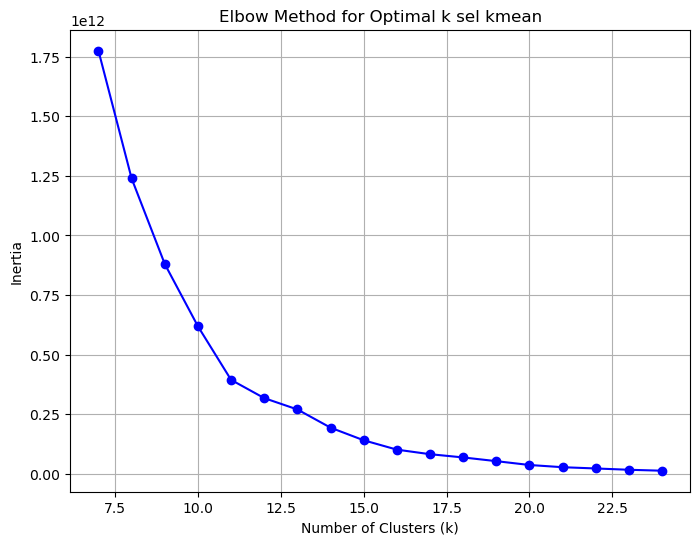

In [65]:
plt.figure(figsize=(8, 6))
plt.plot(k_values, sel_inertia_val, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k sel kmean')
plt.xlabel('Number of Clusters (k)')
#plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [35]:
Sel_exceptloc = selected_features.copy()
exceptloc_copy = selected_copy.copy()

In [36]:
exceptloc_copy.drop(columns = ['CustLocation'],inplace=True)

In [47]:
exceptloc_inertia_val = []
k_values= range(7,25)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_exceptloc_labels = kmeans.fit_predict(exceptloc_copy)
    sel_exceptloc_inertia = kmeans.inertia_
    exceptloc_inertia_val.append(sel_exceptloc_inertia)

In [70]:
k=18
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_exceptloc_labels = kmeans.fit_predict(exceptloc_copy)

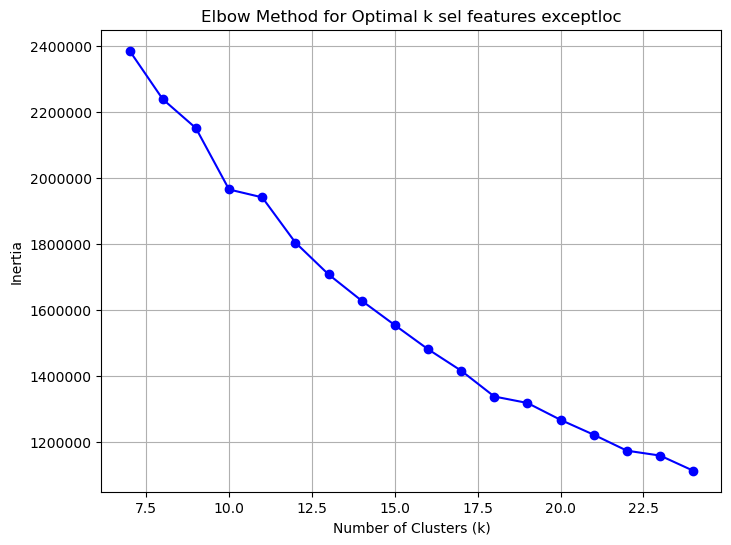

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(k_values, exceptloc_inertia_val, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k sel features exceptloc')
plt.xlabel('Number of Clusters (k)')
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [38]:
print(f'RFM inertia  {RFM_inertia} ')
print(f'scaled_rfm_ inertia  {scaled_rfm_inertia} ')
print(f'selected inertia  {selected_inertia} ')
print(f'sel_exceptloc inertia  {sel_exceptloc_inertia} ')

RFM inertia  335541111737.67523 
scaled_rfm_ inertia  118285.78432619973 
selected inertia  1238933724075.213 
sel_exceptloc inertia  2239118.506367429 


In [39]:
#memory error
#from sklearn.cluster import DBSCAN   
#X_scaled=X_scaled.astype(np.float32)
#dbscan_scaledrfm = scaled_deneme.copy()
#dbscan = DBSCAN(eps = 0.5 , min_samples = 10, metric = 'manhattan')
#dbscan_scaledrfm['Clusters'] = dbscan.fit_predict(X_scaled)

In [40]:
from sklearn.mixture import GaussianMixture
n_components = 10  
gmm_scaledrfm = scaled_deneme.copy()
gmm = GaussianMixture(n_components=n_components)
gmm.fit(X_scaled)  
scaledrfm_labels=gmm.predict(X_scaled)
probs = gmm.predict_proba(X_scaled)

In [96]:
n_components = 5  
gmm_selected = selected_copy.copy()
gmm = GaussianMixture(n_components=n_components)
gmm.fit(gmm_selected)  
selected_labels_gmm=gmm.predict(gmm_selected)
probs = gmm.predict_proba(gmm_selected)

In [41]:
n_components = 10  
gmm_exceptloc = Sel_exceptloc.copy()
gmm2 = GaussianMixture(n_components=n_components)
gmm2.fit(exceptloc_copy)  
exceptloc_labels=gmm2.predict(exceptloc_copy)
probs = gmm2.predict_proba(exceptloc_copy)

In [97]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin_rfm = davies_bouldin_score(exceptloc_copy, scaledrfm_labels)
davies_bouldin_exceptloc = davies_bouldin_score(exceptloc_copy, exceptloc_labels)
davies_bouldin_kmeans_exceptloc = davies_bouldin_score(exceptloc_copy, kmeans_exceptloc_labels)
davies_bouldin_kmeans_rfm = davies_bouldin_score(exceptloc_copy, scaled_deneme['Cluster'])
davies_bouldin_kmeans_sel = davies_bouldin_score(selected_copy, kmeans_sel_labels)
davies_bouldin_gmm_sel = davies_bouldin_score(gmm_selected, selected_labels_gmm)
print("Davies-Bouldin Index For RFM with GMM:", davies_bouldin_rfm)
print("Davies-Bouldin Index For RFM with Kmeans:", davies_bouldin_kmeans_rfm)
print("Davies-Bouldin Index For exceptloc with GMM :", davies_bouldin_exceptloc)
print("Davies-Bouldin Index For exceptloc with Kmeans:", davies_bouldin_kmeans_exceptloc)
print("Davies-Bouldin Index For selected features with Kmeans:", davies_bouldin_kmeans_sel)
print("Davies-Bouldin Index For selected features with GMM:", davies_bouldin_gmm_sel)

Davies-Bouldin Index For RFM with GMM: 4.318520591203549
Davies-Bouldin Index For RFM with Kmeans: 2.8156786761421224
Davies-Bouldin Index For exceptloc with GMM : 2.7398763815258507
Davies-Bouldin Index For exceptloc with Kmeans: 1.1826474870831905
Davies-Bouldin Index For selected features with Kmeans: 0.22092296419111562
Davies-Bouldin Index For selected features with GMM: 10.972026053377002


Text(0.5, 0.92, '3D Scatter Plot of Clusters')

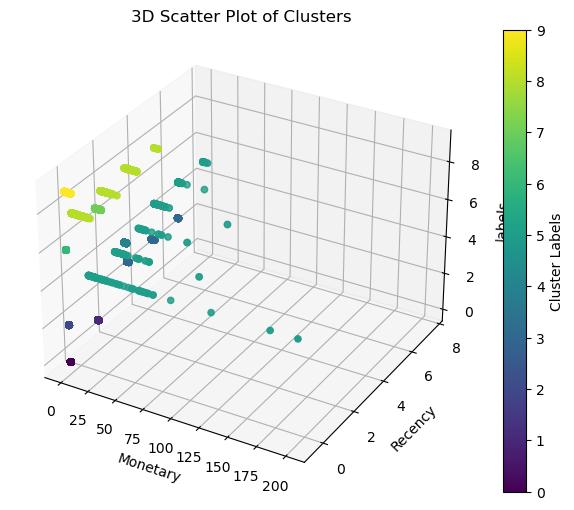

In [68]:
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Assuming 'features' is a numpy array containing your important features
# and 'predicted_labels' contains the cluster labels predicted by your clustering algorithm

# Create a figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the data points with colors based on the predicted labels
scatter = ax.scatter(X_scaled[:, 2], X_scaled[:, 1],scaledrfm_labels, c=scaledrfm_labels, cmap='viridis')

# Add labels to the axes
ax.set_xlabel('Monetary')
ax.set_ylabel('Recency')
ax.set_zlabel('labels')

# Add a colorbar for reference
cbar = fig.colorbar(scatter)
cbar.set_label('Cluster Labels')

# Set a title for the plot
plt.title('3D Scatter Plot of Clusters')

# Show the plot

Text(0.5, 0.92, '3D Scatter Plot of Clusters')

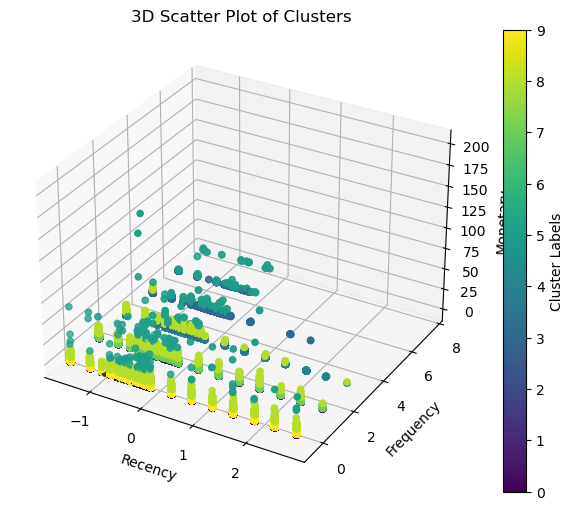

In [69]:
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Assuming 'features' is a numpy array containing your important features
# and 'predicted_labels' contains the cluster labels predicted by your clustering algorithm

# Create a figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the data points with colors based on the predicted labels
scatter = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=scaledrfm_labels, cmap='viridis')

# Add labels to the axes
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# Add a colorbar for reference
cbar = fig.colorbar(scatter)
cbar.set_label('Cluster Labels')

# Set a title for the plot
plt.title('3D Scatter Plot of Clusters')

In [75]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

num_components = 3

pca = PCA(n_components=num_components)

principal_components = pca.fit_transform(exceptloc_copy)

principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(num_components)])

explained_variance_ratios = pca.explained_variance_ratio_

print("Explained Variance Ratios:", explained_variance_ratios)

Explained Variance Ratios: [0.23628252 0.18841315 0.16863849]


In [80]:
principal_df

,PC1,PC2,PC3
0,-2.000507,0.436890,0.645744
1,-0.709734,2.529260,3.208678
2,-1.980836,0.468067,0.685487
3,0.878420,0.658503,-0.485095
4,-1.935940,0.522291,0.803057
...,...,...,...
916034,-0.160064,-0.334075,-0.225509
916035,-0.173732,-0.340466,-0.271115
916036,0.992602,-0.315704,-0.367166
916037,-0.128452,-0.224627,-0.201531


Text(0.5, 0.92, '3D Scatter Plot of Clusters exceptloc GMM')

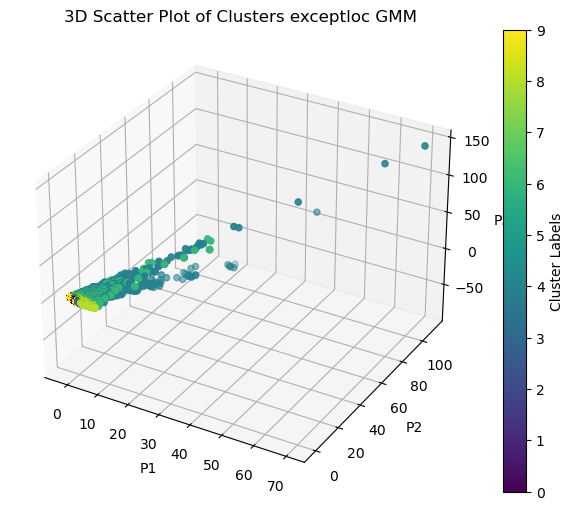

In [82]:
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Assuming 'features' is a numpy array containing your important features
# and 'predicted_labels' contains the cluster labels predicted by your clustering algorithm

# Create a figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the data points with colors based on the predicted labels
scatter = ax.scatter(principal_df['PC1'], principal_df['PC2'], principal_df['PC3'], c=exceptloc_labels, cmap='viridis')

# Add labels to the axes
ax.set_xlabel('P1')
ax.set_ylabel('P2')
ax.set_zlabel('P3')

# Add a colorbar for reference
cbar = fig.colorbar(scatter)
cbar.set_label('Cluster Labels')

# Set a title for the plot
plt.title('3D Scatter Plot of Clusters exceptloc GMM')

Text(0.5, 0.92, '3D Scatter Plot of Clusters exceptloc Kmean')

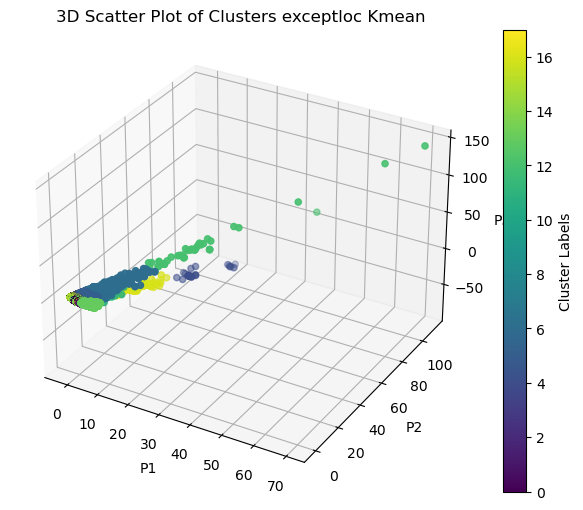

In [83]:
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Assuming 'features' is a numpy array containing your important features
# and 'predicted_labels' contains the cluster labels predicted by your clustering algorithm

# Create a figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the data points with colors based on the predicted labels
scatter = ax.scatter(principal_df['PC1'], principal_df['PC2'], principal_df['PC3'], c=kmeans_exceptloc_labels, cmap='viridis')

# Add labels to the axes
ax.set_xlabel('P1')
ax.set_ylabel('P2')
ax.set_zlabel('P3')

# Add a colorbar for reference
cbar = fig.colorbar(scatter)
cbar.set_label('Cluster Labels')

# Set a title for the plot
plt.title('3D Scatter Plot of Clusters exceptloc Kmean')

In [84]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

num_components = 3

pca = PCA(n_components=num_components)

principal_components1 = pca.fit_transform(selected_copy)

principal_df1 = pd.DataFrame(data=principal_components1, columns=[f'PC{i+1}' for i in range(num_components)])

explained_variance_ratios = pca.explained_variance_ratio_

print("Explained Variance Ratios:", explained_variance_ratios)

Explained Variance Ratios: [9.99999995e-01 1.15256627e-09 9.18125616e-10]


Text(0.5, 0.92, '3D Scatter Plot of Clusters exceptloc Kmean')

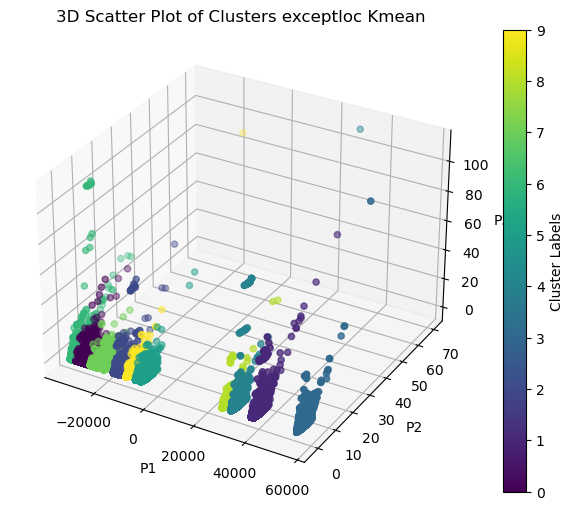

In [87]:
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Assuming 'features' is a numpy array containing your important features
# and 'predicted_labels' contains the cluster labels predicted by your clustering algorithm

# Create a figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the data points with colors based on the predicted labels
scatter = ax.scatter(principal_df1['PC1'], principal_df1['PC2'], principal_df1['PC3'], c=kmeans_sel_labels, cmap='viridis')

# Add labels to the axes
ax.set_xlabel('P1')
ax.set_ylabel('P2')
ax.set_zlabel('P3')

# Add a colorbar for reference
cbar = fig.colorbar(scatter)
cbar.set_label('Cluster Labels')

# Set a title for the plot
plt.title('3D Scatter Plot of Clusters exceptloc Kmean')

In [93]:
k=5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_sel_labels1 = kmeans.fit_predict(selected_copy)

Text(0.5, 0.92, '3D Scatter Plot of Clusters exceptloc Kmean')

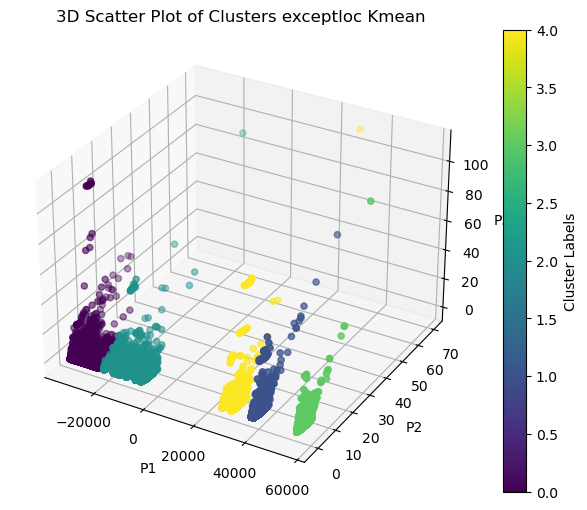

In [94]:
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Assuming 'features' is a numpy array containing your important features
# and 'predicted_labels' contains the cluster labels predicted by your clustering algorithm

# Create a figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the data points with colors based on the predicted labels
scatter = ax.scatter(principal_df1['PC1'], principal_df1['PC2'], principal_df1['PC3'], c=kmeans_sel_labels1, cmap='viridis')

# Add labels to the axes
ax.set_xlabel('P1')
ax.set_ylabel('P2')
ax.set_zlabel('P3')

# Add a colorbar for reference
cbar = fig.colorbar(scatter)
cbar.set_label('Cluster Labels')

# Set a title for the plot
plt.title('3D Scatter Plot of Clusters exceptloc Kmean')

Text(0.5, 0.92, '3D Scatter Plot of Clusters exceptloc Kmean')

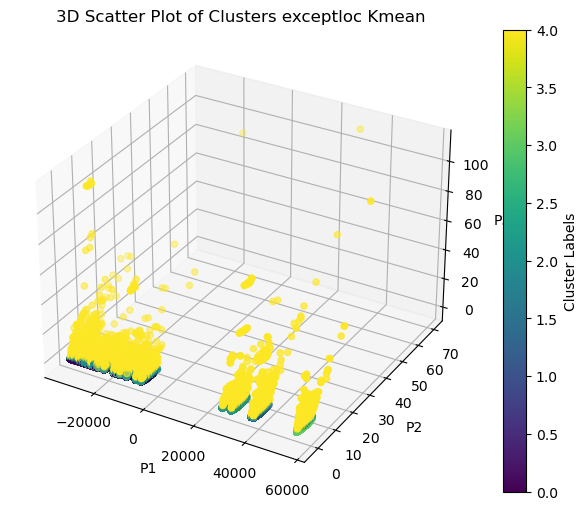

In [98]:
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Assuming 'features' is a numpy array containing your important features
# and 'predicted_labels' contains the cluster labels predicted by your clustering algorithm

# Create a figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the data points with colors based on the predicted labels
scatter = ax.scatter(principal_df1['PC1'], principal_df1['PC2'], principal_df1['PC3'], c=selected_labels_gmm, cmap='viridis')

# Add labels to the axes
ax.set_xlabel('P1')
ax.set_ylabel('P2')
ax.set_zlabel('P3')

# Add a colorbar for reference
cbar = fig.colorbar(scatter)
cbar.set_label('Cluster Labels')

# Set a title for the plot
plt.title('3D Scatter Plot of Clusters exceptloc Kmean')